### This jupyter notebook employs a fully connective neural network(FC) or its alias artificial neural network (ANN) to learn the mapping between input current configuration between output magnetic field 

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import torch
from early_stopping import EarlyStopping

if torch.cuda.device_count():
    device = 'cuda'
    print('Good to go')
else:
    device = 'cpu'
    print('Using cpu')

Good to go


In [3]:
from ReadData import ReadCurrentAndField 
import glob
import os 

# print(os.getcwd())
foldername="./Data/"
filepattern = "MagneticField[0-9]*.txt"
#data = ReadFolder(foldername,filepattern)
train_file_num = 50
data = ReadCurrentAndField (foldername,filepattern)

fileList = glob.glob(foldername+filepattern)


data=data.reshape(1460,21,21,21,18)
position = data[:,0:20:2,0:20:2,0:20:2,:15].reshape(-1,15)
Bfield = data[:,0:20:2,0:20:2,0:20:2,15:].reshape(-1,3)


print(fileList)
print(data.shape)
print('position shape', position.shape)
print('Bfield shape', Bfield.shape)

['./Data\\MagneticField0.txt', './Data\\MagneticField1.txt', './Data\\MagneticField10.txt', './Data\\MagneticField100.txt', './Data\\MagneticField1000.txt', './Data\\MagneticField1001.txt', './Data\\MagneticField1002.txt', './Data\\MagneticField1003.txt', './Data\\MagneticField1004.txt', './Data\\MagneticField1005.txt', './Data\\MagneticField1006.txt', './Data\\MagneticField1007.txt', './Data\\MagneticField1008.txt', './Data\\MagneticField1009.txt', './Data\\MagneticField101.txt', './Data\\MagneticField1010.txt', './Data\\MagneticField1011.txt', './Data\\MagneticField1012.txt', './Data\\MagneticField1013.txt', './Data\\MagneticField1014.txt', './Data\\MagneticField1015.txt', './Data\\MagneticField1016.txt', './Data\\MagneticField1017.txt', './Data\\MagneticField1018.txt', './Data\\MagneticField1019.txt', './Data\\MagneticField102.txt', './Data\\MagneticField1020.txt', './Data\\MagneticField1021.txt', './Data\\MagneticField1022.txt', './Data\\MagneticField1023.txt', './Data\\MagneticFie

In [4]:
#find min and max value of input position and Bfield
max_position, max_position_index = torch.max(position, dim=0, keepdim=True)
print(max_position)
min_position, min_position_index = torch.min(position, dim=0, keepdim=True)
print(min_position)

max_Bfield, max_Bfield_index = torch.max(Bfield, dim=0, keepdim=True)
print(max_Bfield)
min_Bfield, min_Bfield_index = torch.min(Bfield, dim=0, keepdim=True)
print(min_Bfield)

position_norm = (position-min_position.expand(position.shape[0],position.shape[1]))/(max_position.expand(position.shape[0],position.shape[1])-min_position.expand(position.shape[0],position.shape[1]))
Bfield_norm = (Bfield-min_Bfield.expand(Bfield.shape[0],Bfield.shape[1]))/(max_Bfield.expand(Bfield.shape[0],Bfield.shape[1])-min_Bfield.expand(Bfield.shape[0],Bfield.shape[1]))

tensor([[14.9943, 14.9997, 14.9988, 14.9575, 14.9915, 14.9808, 14.9884, 14.9878,
         14.9549, 14.9957, 14.9494, 14.9705,  0.0400,  0.0400,  0.0400]])
tensor([[-14.9800, -14.9944, -14.9962, -14.9903, -14.9597, -14.9911, -14.9693,
         -14.9875, -14.9992, -14.9837, -14.9949, -14.9139,  -0.0500,  -0.0500,
          -0.0500]])
tensor([[0.0525, 0.0638, 0.0608]])
tensor([[-0.0557, -0.0575, -0.0639]])


In [7]:
from Neural_network import NN_net, Plain_fc_block, weight_init, eMNS_Dataset
from Training_loop import train_part_v1
batch_size = 128
# construct dataset
dataset = eMNS_Dataset(
    train_x=position_norm,
    train_y=Bfield_norm
)
###############################################
# Config the neural network
###############################################
num_input = 15
num_output = 3
fc_stages = [(num_input,100,1),(100,50,1),(50,25,1)]
fc_network = NN_net(None,fc_stages,None,Plain_fc_block, num_output=num_output)
epochs = 50
learning_rate_decay = .1
learning_rates = [1e-3]
schedule = []
weight_decays = [0]

train_percents = np.arange(0.9,0.95,0.1)
RMSE_history_end = np.zeros(len(train_percents))
RMSE_val_history_end = np.zeros(len(train_percents))
loss_history_end = np.zeros(len(train_percents))
iter_history_end = np.zeros(len(train_percents))
loss_val_history_end = np.zeros(len(train_percents))
train_stop_epoch = np.zeros(len(train_percents))

################################################
# Train the neural network
################################################
index=0
for train_percent in train_percents:
    epoch_stop = 0
    print('train_percent',train_percent)
    for learning_rate in learning_rates:
        for weight_decay in weight_decays:

            # split the dataset to train, validation, test
            train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [train_percent*0.9,train_percent*0.1,1.0-train_percent])

            #Using Dataloader for batch train
            train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
            valid_loader = torch.utils.data.DataLoader(dataset=valid_set,batch_size=batch_size,shuffle=True)
            test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)

            fc_network.apply(weight_init)
            optimizer = torch.optim.Adam([{'params':fc_network.parameters()}], lr=learning_rate, weight_decay= weight_decay)
            RMSE_history, RMSE_val_history, loss_history, iter_history, loss_val_history,epoch_stop = train_part_v1(model=fc_network, optimizer=optimizer, train_loader=train_loader, valid_loader=valid_loader, epochs=epochs, learning_rate_decay=learning_rate_decay, schedule=schedule, weight_decay=weight_decay, verbose=False, device=device)
    
    #save RMSE and loss after early stopping
    RMSE_history_end[index] = RMSE_history[epoch_stop]
    RMSE_val_history_end[index]= RMSE_val_history[epoch_stop]
    loss_history_end[index] = loss_history[epoch_stop]
    iter_history_end[index] = iter_history[epoch_stop]
    loss_val_history_end[index] = loss_val_history[epoch_stop]
    index=index+1
    print('training stop at epoch:',epoch_stop)


train_percent 0.9
Epoch 0, Iteration 9240, loss = 0.0078
Got rmse 0.15921321511268616
Got rmse 0.159404456615448

Validation loss decreased (inf --> 0.007841).  Saving model ...
Epoch 1, Iteration 18480, loss = 0.0032
Got rmse 0.12511689960956573
Got rmse 0.12518751621246338

Validation loss decreased (0.007841 --> 0.003229).  Saving model ...
Epoch 2, Iteration 27720, loss = 0.0039
Got rmse 0.12201083451509476
Got rmse 0.12187191843986511

EarlyStopping counter: 1 out of 5
Epoch 3, Iteration 36960, loss = 0.0028
Got rmse 0.11002815514802933
Got rmse 0.10997816175222397

Validation loss decreased (0.003229 --> 0.002801).  Saving model ...
Epoch 4, Iteration 46200, loss = 0.0026
Got rmse 0.11185536533594131
Got rmse 0.11166645586490631

Validation loss decreased (0.002801 --> 0.002582).  Saving model ...
Epoch 5, Iteration 55440, loss = 0.0039
Got rmse 0.10856039077043533
Got rmse 0.10851777344942093

EarlyStopping counter: 1 out of 5
Epoch 6, Iteration 64680, loss = 0.0040
Got rmse 0.0

In [8]:
torch.save(fc_network, 'EMS_ANN.pt')	# 这里会存储迄今最优模型的参数

[autoreload of Training_loop failed: Traceback (most recent call last):
  File "c:\Users\14032\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\14032\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "c:\Users\14032\AppData\Local\Programs\Python\Python312\Lib\importlib\__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 990, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1128, in get_code
  File "<frozen importlib._bootstrap_external>", line 1058, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "d:\QubotGit\QubotGitFile\Qubot_Elas

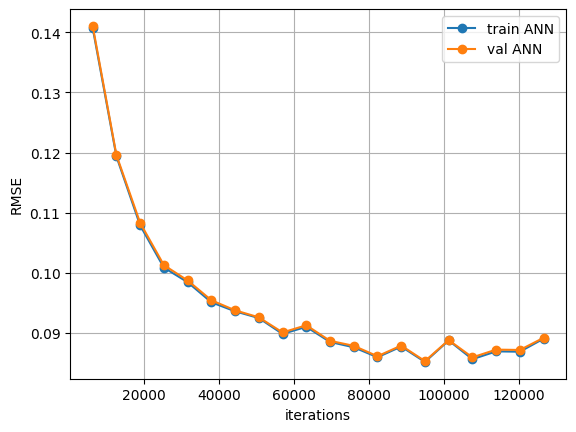

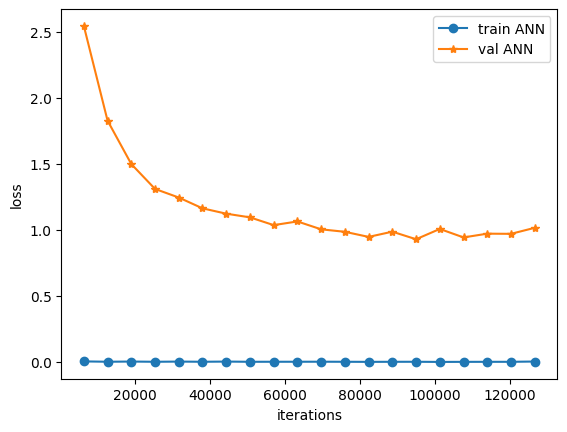

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
ave_site = 5
ave_kernel = 1/ave_site*np.ones(ave_site)
loss_history_conv = np.convolve(loss_history.numpy(),ave_kernel,'same')
plt.plot(iter_history[0:epoch_stop],RMSE_history[0:epoch_stop],'-o')
plt.plot(iter_history[0:epoch_stop],RMSE_val_history[0:epoch_stop],'-o')
plt.legend(['train ANN','val ANN'])
plt.xlabel('iterations')
plt.ylabel('RMSE')
plt.grid()
plt.show()

plt.plot(iter_history[0:epoch_stop],loss_history[0:epoch_stop],'-o')
plt.plot(iter_history[0:epoch_stop],loss_val_history[0:epoch_stop],'-*')
plt.legend(['train ANN','val ANN'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

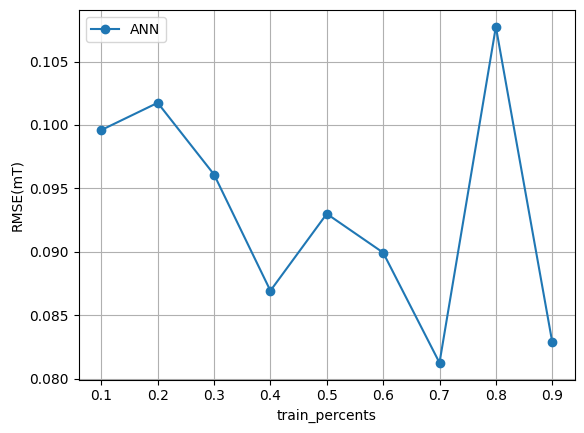

In [ ]:
plt.plot(train_percents,RMSE_val_history_end,'-o')
plt.xlabel('train_percents')
plt.ylabel('RMSE(mT)')
# plt.ylim([0,25])
plt.grid()
plt.legend(['ANN'])
plt.show()

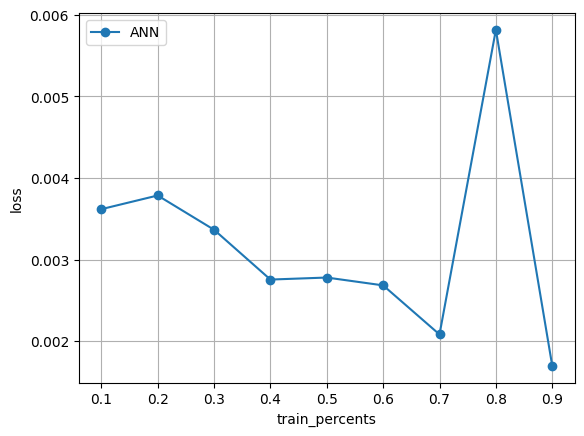

In [ ]:
plt.plot(train_percents,loss_history_end,'-o')
plt.xlabel('train_percents')
plt.ylabel('loss')
plt.legend(['ANN'])
plt.grid()
plt.show()